# Analisis Saham

In [1]:
# Install Library yang diperlukan
!pip install yfinance

## Import Library

In [40]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input

import math
from sklearn.metrics import mean_squared_error

import joblib
from google.colab import files

from tensorflow.keras.models import load_model
import os
import tensorflow as tf

import zipfile

from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_absolute_error

## Data Ingestion (Pengambilan Data)

In [3]:
kode_saham = 'BBRI.JK'
start_date = '2015-01-01'
end_date = '2025-12-31'

print(f" Sedang mengunduh data {kode_saham}...")
df = yf.download(kode_saham, start=start_date, end=end_date, auto_adjust=True)

# Hapus baris yang kosong
df = df.dropna()

print(f"Data berhasil diambil! Total baris: {len(df)}")
df.tail(20)

 Sedang mengunduh data BBRI.JK...


[*********************100%***********************]  1 of 1 completed

Data berhasil diambil! Total baris: 2691


Price,Close,High,Low,Open,Volume
Ticker,BBRI.JK,BBRI.JK,BBRI.JK,BBRI.JK,BBRI.JK
Date,,,,,
2025-11-03,4040.0,4050.0,4010.0,4050.0,163770500
2025-11-04,3970.0,4050.0,3970.0,4030.0,241154700
2025-11-05,3980.0,3990.0,3910.0,3940.0,139859100
2025-11-06,4000.0,4010.0,3950.0,3980.0,130808100
2025-11-07,3980.0,4010.0,3980.0,4000.0,87287600
2025-11-10,3930.0,4020.0,3930.0,4010.0,148552900
2025-11-11,3890.0,3960.0,3860.0,3940.0,179000200
2025-11-12,3900.0,3950.0,3890.0,3890.0,111115400


## EDA (Exploratory Data Analysis)

In [4]:
# cek data duplikat
df.duplicated().sum()

np.int64(30)

In [5]:
# cek informasi lengkap dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2691 entries, 2015-01-02 to 2025-11-28
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BBRI.JK)   2691 non-null   float64
 1   (High, BBRI.JK)    2691 non-null   float64
 2   (Low, BBRI.JK)     2691 non-null   float64
 3   (Open, BBRI.JK)    2691 non-null   float64
 4   (Volume, BBRI.JK)  2691 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 126.1 KB


In [6]:
df.describe()

Price,Close,High,Low,Open,Volume
Ticker,BBRI.JK,BBRI.JK,BBRI.JK,BBRI.JK,BBRI.JK
count,2691.000000,2691.000000,2691.000000,2691.000000,2.691000e+03
mean,2827.464195,2860.161022,2797.423255,2829.692740,1.606469e+08
std,1139.751084,1151.566633,1129.855714,1140.901565,1.058360e+08
min,982.864258,991.745472,944.378565,953.259855,0.000000e+00
25%,1886.679688,1899.939235,1861.468814,1881.065308,9.515577e+07
50%,2787.876709,2819.850891,2755.456674,2786.281052,1.336786e+08
75%,3766.434814,3808.986328,3725.584174,3774.604859,1.954036e+08
max,5763.100098,5785.969664,5694.491883,5763.100219,1.000598e+09


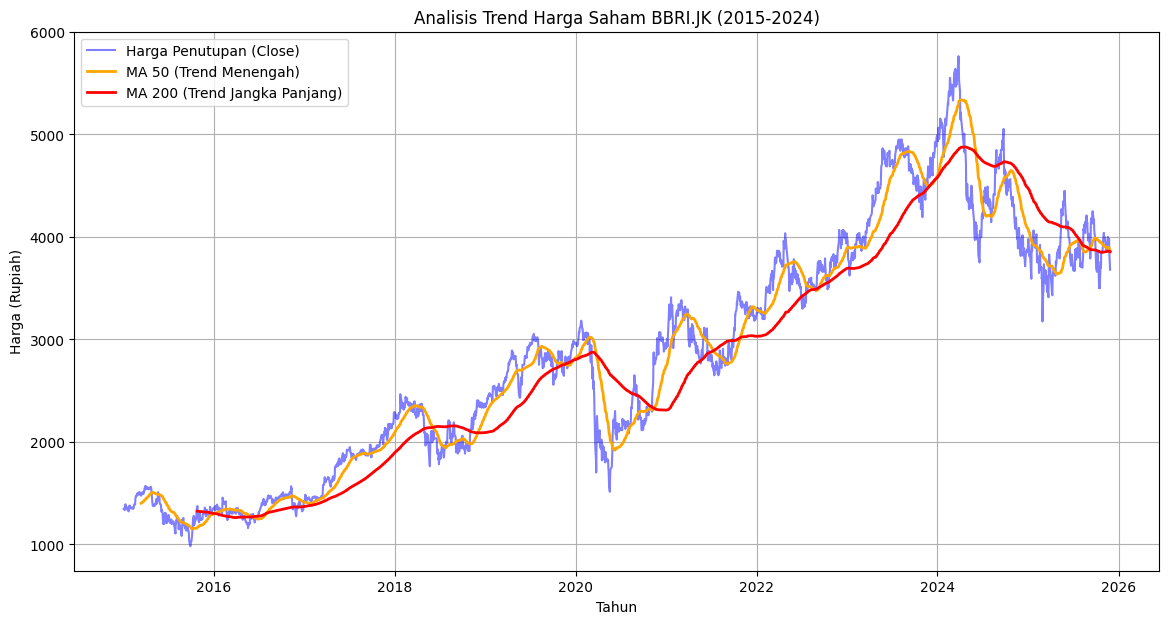


Jumlah Data Kosong per Kolom:
Price   Ticker 
Close   BBRI.JK      0
High    BBRI.JK      0
Low     BBRI.JK      0
Open    BBRI.JK      0
Volume  BBRI.JK      0
MA50                49
MA200              199
dtype: int64


In [7]:
plt.figure(figsize=(14, 7))

# Plot Harga Asli (Close)
# alpha=0.5 membuat garis agak transparan biar tidak menutupi garis lain
plt.plot(df['Close'], label='Harga Penutupan (Close)', color='blue', alpha=0.5)

# Menghitung Moving Average (Rata-rata Bergerak)
# MA50 = Rata-rata harga 50 hari terakhir
df['MA50'] = df['Close'].rolling(window=50).mean()
plt.plot(df['MA50'], label='MA 50 (Trend Menengah)', color='orange', linewidth=2)

# MA200 = Rata-rata harga 200 hari terakhir
df['MA200'] = df['Close'].rolling(window=200).mean()
plt.plot(df['MA200'], label='MA 200 (Trend Jangka Panjang)', color='red', linewidth=2)

plt.title(f'Analisis Trend Harga Saham {kode_saham} (2015-2024)')
plt.xlabel('Tahun')
plt.ylabel('Harga (Rupiah)')
plt.legend()
plt.grid(True)
plt.show()

# Cek apakah ada data yang hilang (Missing Values)
print("\nJumlah Data Kosong per Kolom:")
print(df.isnull().sum())

## Preprocessing Data

In [8]:
# Ambil hanya kolom 'Close'
data = df[['Close']].values

# Normalisasi (Scaling) ke angka 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

print(f"Contoh harga asli: {data[0][0]}")
print(f"Contoh harga setelah discale: {scaled_data[0][0]}")

Contoh harga asli: 1348.5760498046875
Contoh harga setelah discale: 0.07650496842518575


In [9]:
# Membagi Data Training (80%) dan Testing (20%)
# Kita potong berdasarkan urutan waktu, bukan diacak
training_data_len = int(np.ceil(len(scaled_data) * .8))

train_data = scaled_data[0:training_data_len, :]
test_data = scaled_data[training_data_len:, :]

print(f"Total Data: {len(scaled_data)}")
print(f"Data Latihan (Training): {len(train_data)} baris (2015 - awal 2024)")
print(f"Data Ujian (Testing): {len(test_data)} baris (2024 - 2025)")

Total Data: 2691
Data Latihan (Training): 2153 baris (2015 - awal 2024)
Data Ujian (Testing): 538 baris (2024 - 2025)


In [10]:
# Membuat Struktur Data LSTM (Sliding Window)
# X = 60 hari lalu, y = Hari ini.
def create_dataset(dataset, time_step=60):
    data_X, data_Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0] # Ambil 60 hari sebagai train
        data_X.append(a)
        data_Y.append(dataset[i + time_step, 0]) # Ambil hari ke-61 sebagai test
    return np.array(data_X), np.array(data_Y)

# Set 'window' 60 hari
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Ubah bentuk data agar bisa diproses LSTM [Samples, Time Steps, Features]
# LSTM butuh input 3 Dimensi
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print("Bentuk Data Siap Masuk LSTM:")
print(f"X_train shape: {X_train.shape} <-- (Jumlah Data, Window 60 hari, 1 Fitur)")
print(f"y_train shape: {y_train.shape}")

Bentuk Data Siap Masuk LSTM:
X_train shape: (2092, 60, 1) <-- (Jumlah Data, Window 60 hari, 1 Fitur)
y_train shape: (2092,)


## Modeling & Training

In [11]:
# Jika setelah LSTM ada LSTM lagi return_sequences Wajib True.
# Jika setelah LSTM adalah Dense return_sequences Wajib False (biasanya).

# Membangun Arsitektur Model
model = Sequential()

# Tambahkan Input Layer
model.add(Input(shape=(X_train.shape[1], 1)))

# Layer LSTM Pertama
# return_sequences=True artinya: "Teruskan ingatanmu ke layer LSTM berikutnya"
model.add(LSTM(units=50, return_sequences=True))

# Layer LSTM Kedua
# return_sequences=False artinya: "Cukup, jangan teruskan lagi. Rangkum semuanya di sini."
model.add(LSTM(units=50, return_sequences=False))

# Layer Dense (Output)
# 25 neuron untuk berpikir lebih dalam
model.add(Dense(25))
# 1 neuron terakhir untuk menebak satu angka harga (Rupiah)
model.add(Dense(1))

In [12]:
# Compile & Training

# Loss 'mean_squared_error': semakin kecil error, semakin bagus
model.compile(optimizer='adam', loss='mean_squared_error')

print("Mulai melatih model... (Silakan tunggu, mungkin butuh waktu)")
history = model.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1)

Mulai melatih model... (Silakan tunggu, mungkin butuh waktu)
Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0221
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.3188e-04
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.2407e-04
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.7319e-04
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.1501e-04
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.1935e-04
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.2449e-04
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.0233e-04
Epoch 9/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.4888e-04
Epoch 10/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.7076e-04
Epoch 11/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.1484e-04
Epoch 12/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.0838e-04
Epoch 13/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.1042e-04
Epoch 14/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s

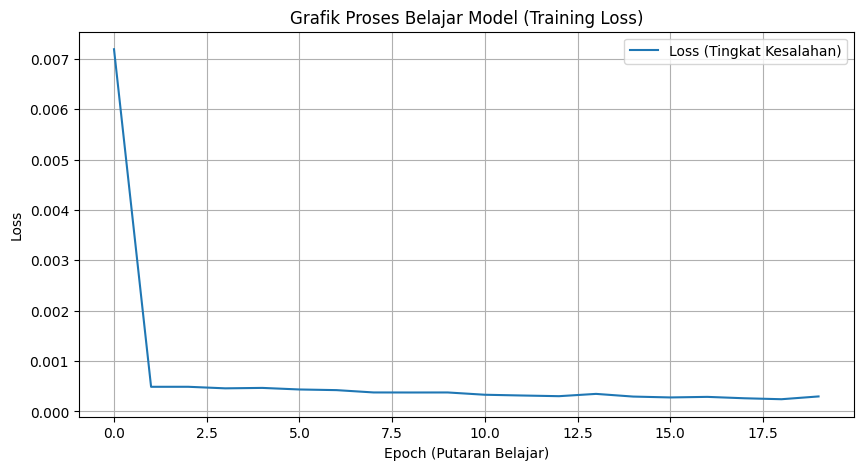

In [13]:
# Visualisasi Training Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Loss (Tingkat Kesalahan)')
plt.title('Grafik Proses Belajar Model (Training Loss)')
plt.xlabel('Epoch (Putaran Belajar)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Prediksi & Evaluasi

In [14]:
# menebak harga berdasarkan X_test
predictions = model.predict(X_test)

# Mengembalikan ke Rupiah (Inverse Transform)

# Karena hasil prediksi masih skala 0-1, kita kembalikan ke format Rupiah
predictions = scaler.inverse_transform(predictions)

# Kita juga perlu data asli y_test dalam rupiah untuk menghitung skor error nanti
# (Caranya: kita ambil data harga asli dari 'df' yang sesuai periode testing)
train = df[:training_data_len]

valid = df.iloc[training_data_len + time_step : training_data_len + len(test_data) - 1].copy()

valid['Predictions'] = predictions

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


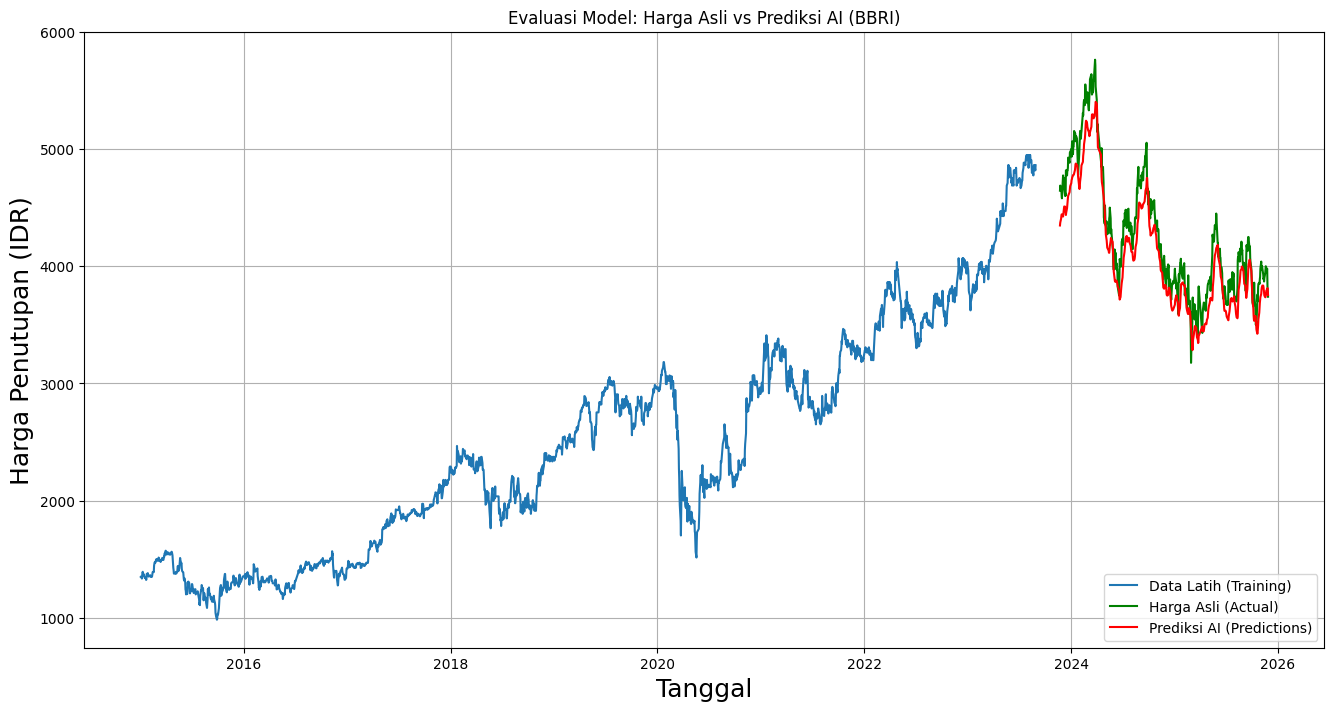


Perbandingan Harga Asli vs Prediksi (5 Hari Terakhir):
Price        Close  Predictions
Ticker     BBRI.JK             
Date                           
2025-11-21  3960.0  3791.913818
2025-11-24  3980.0  3804.123779
2025-11-25  3830.0  3813.388672
2025-11-26  3790.0  3792.566162
2025-11-27  3740.0  3754.166016


In [15]:
# Visualisasi Hasil Prediksi vs Asli
plt.figure(figsize=(16, 8))
plt.title('Evaluasi Model: Harga Asli vs Prediksi AI (BBRI)')
plt.xlabel('Tanggal', fontsize=18)
plt.ylabel('Harga Penutupan (IDR)', fontsize=18)

# Gambar data latihan (Masa lalu)
plt.plot(train['Close'], label='Data Latih (Training)')

# Gambar harga asli saat ujian (Kunci Jawaban)
plt.plot(valid['Close'], label='Harga Asli (Actual)', color='green')

# Gambar tebakan AI
plt.plot(valid['Predictions'], label='Prediksi AI (Predictions)', color='red')

plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Lihat Angkanya Langsung
print("\nPerbandingan Harga Asli vs Prediksi (5 Hari Terakhir):")
print(valid[['Close', 'Predictions']].tail())

## Evaluasi RMSE & Prediksi Hari Esok

In [16]:
# RMSE mengukur rata-rata kesalahan dalam Rupiah
rmse = math.sqrt(mean_squared_error(valid['Close'], valid['Predictions']))
print(f"Skor RMSE (Rata-rata Meleset): Rp {rmse:.2f}")

Skor RMSE (Rata-rata Meleset): Rp 215.13


In [17]:
# Kita ingin memprediksi 1 hari setelah data terakhir yang kita punya
# Ambil 60 hari terakhir dari data yang kita miliki
last_60_days = data[-60:]

# Scale datanya (0-1)
last_60_days_scaled = scaler.transform(last_60_days)

# Bentuk ulang jadi 3 Dimensi (1 sampel, 60 hari, 1 fitur)
X_future = []
X_future.append(last_60_days_scaled)
X_future = np.array(X_future)
X_future = np.reshape(X_future, (X_future.shape[0], X_future.shape[1], 1))

# Prediksi
pred_future = model.predict(X_future)
pred_future_price = scaler.inverse_transform(pred_future)

print(f"🔮 Prediksi Harga BBRI untuk HARI BERIKUTNYA:")
print(f"Rp {pred_future_price[0][0]:,.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
🔮 Prediksi Harga BBRI untuk HARI BERIKUTNYA:
Rp 3,648.86


## Tambah Fitur

## Menghitung Indikator (Feature Engineering)

In [18]:
# Menghitung RSI (Relative Strength Index)
def calculate_rsi(data, window=14):
    delta = data['Close'].diff() # Selisih harga hari ini vs kemarin
    gain = (delta.where(delta > 0, 0)) # Ambil yang untung (positif)
    loss = (-delta.where(delta < 0, 0)) # Ambil yang rugi (negatif)

    # Rata-rata keuntungan/kerugian (Exponential Moving Average)
    avg_gain = gain.ewm(com=window-1, min_periods=window).mean()
    avg_loss = loss.ewm(com=window-1, min_periods=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = calculate_rsi(df)

In [19]:
# Menghitung MACD
# EMA (Exponential Moving Average) memberi bobot lebih pada data terbaru
k = df['Close'].ewm(span=12, adjust=False, min_periods=12).mean() # EMA 12 Hari (Cepat)
d = df['Close'].ewm(span=26, adjust=False, min_periods=26).mean() # EMA 26 Hari (Lambat)

df['MACD'] = k - d # Garis MACD (Selisih Cepat - Lambat)
df['Signal'] = df['MACD'].ewm(span=9, adjust=False, min_periods=9).mean() # Garis Sinyal

In [20]:
# Membersihkan Data

# Karena perhitungan indikator butuh data hari sebelumnya (misal 26 hari),
# maka 26 baris pertama pasti kosong (NaN). Kita harus buang.
print("Jumlah data sebelum dibersihkan:", len(df))
df_multivariate = df.dropna()
print("Jumlah data setelah dibuang yang kosong:", len(df_multivariate))

# Cek hasilnya
print("\nIntip Data Baru (Sekarang ada kolom RSI dan MACD):")
print(df_multivariate[['Close', 'RSI', 'MACD', 'Signal']].tail())

Jumlah data sebelum dibersihkan: 2691
Jumlah data setelah dibuang yang kosong: 2492

Intip Data Baru (Sekarang ada kolom RSI dan MACD):
Price        Close        RSI       MACD     Signal
Ticker     BBRI.JK                                 
Date                                               
2025-11-24  3980.0  56.463743  33.071108  29.526613
2025-11-25  3830.0  43.401224  21.049280  27.831146
2025-11-26  3790.0  40.697407   8.199707  23.904858
2025-11-27  3740.0  37.548480  -5.949670  17.933953
2025-11-28  3680.0  34.135256 -21.753886   9.996385


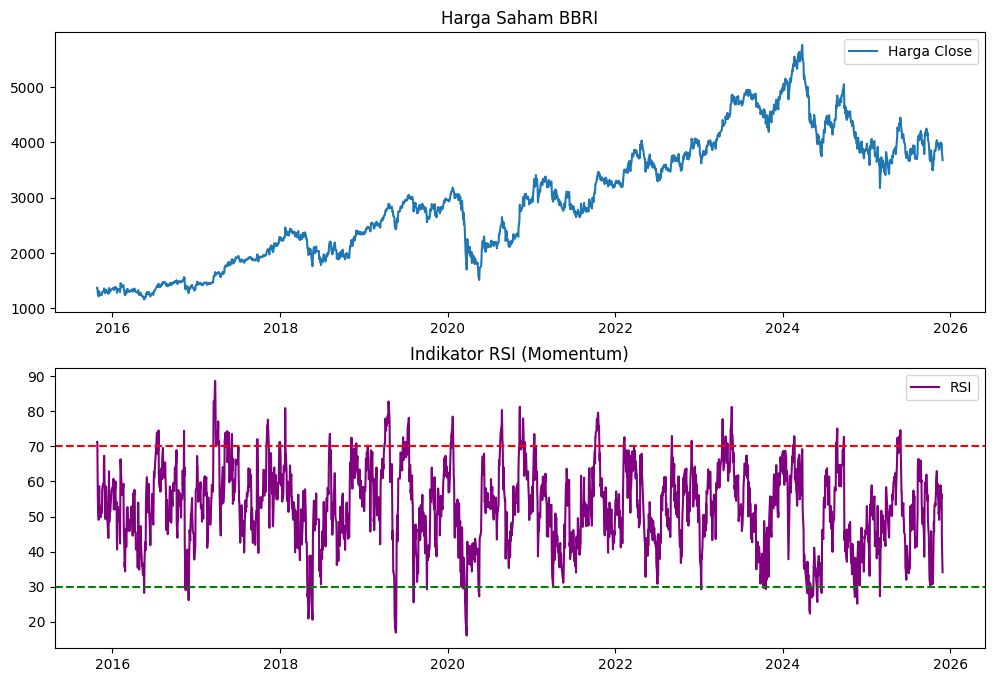

In [21]:
# Visualisasi
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(df_multivariate['Close'], label='Harga Close')
plt.title('Harga Saham BBRI')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df_multivariate['RSI'], color='purple', label='RSI')
plt.axhline(70, color='red', linestyle='--') # Batas Atas
plt.axhline(30, color='green', linestyle='--') # Batas Bawah
plt.title('Indikator RSI (Momentum)')
plt.legend()
plt.show()

In [22]:
# Definisikan Kolom Apa Saja yang Mau Dipakai
feature_columns = ['Close', 'RSI', 'MACD', 'Signal'] # Input
target_column = ['Close']                            # Output

# Buat 2 Scaler Berbeda
# Scaler X: Untuk mengubah semua fitur input jadi 0-1
scaler_X = MinMaxScaler(feature_range=(0, 1))

# Scaler y: khusus untuk harga Close (biar gampang dibalikin ke Rupiah nanti)
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Lakukan Scaling
# Fitur Input (X): Ambil 4 kolom
scaled_features = scaler_X.fit_transform(df_multivariate[feature_columns])

# Target Output (y): Ambil 1 kolom saja
scaled_target = scaler_y.fit_transform(df_multivariate[target_column])

print("✅ Scaling Selesai!")
print(f"Shape Data Fitur (Input AI): {scaled_features.shape} <-- (Baris, 4 Kolom)")
print(f"Shape Data Target (Kunci Jawaban): {scaled_target.shape} <-- (Baris, 1 Kolom)")

print("\nContoh Data Baris Pertama (Sudah 0-1 semua):")
print(scaled_features[0])

✅ Scaling Selesai!
Shape Data Fitur (Input AI): (2492, 4) <-- (Baris, 4 Kolom)
Shape Data Target (Kunci Jawaban): (2492, 1) <-- (Baris, 1 Kolom)

Contoh Data Baris Pertama (Sudah 0-1 semua):
[0.04650436 0.76057737 0.72500981 0.68869638]


## Update Windowing (Memotong Data Gaya Baru)

In [23]:
def create_multivariate_dataset(X, y, time_step=60):
    data_X, data_Y = [], []
    # Loop dari hari ke-60 sampai data habis
    for i in range(len(X) - time_step):
        # Ambil 60 baris data fitur (Close, RSI, MACD, Signal) sebagai train
        data_X.append(X[i:(i + time_step)])

        # Ambil 1 baris data target (Close besoknya) sebagai test
        data_Y.append(y[i + time_step])

    return np.array(data_X), np.array(data_Y)

# Atur ulang time_step
time_step = 60

# Potong Data jadi train (X) dan test (y)
X, y = create_multivariate_dataset(scaled_features, scaled_target, time_step)

# Pisahkan Training (80%) dan Testing (20%)
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("✅ Data Siap!")
print(f"X_train shape: {X_train.shape} <-- (Jumlah Data, 60 Hari, 4 FITUR)")
print(f"y_train shape: {y_train.shape}")

✅ Data Siap!
X_train shape: (1945, 60, 4) <-- (Jumlah Data, 60 Hari, 4 FITUR)
y_train shape: (1945, 1)


## Rakit Ulang & Latih Model (Multivariate)

In [24]:
# Rakit Ulang Model
model = Sequential()

# Tambahkan Input Layer
model.add(Input(shape=(X_train.shape[1], 4))) # Definisikan bentuk input di sini

# Layer 1: Sekarang tanpa input_shape karena sudah ada Input Layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2)) # Trik baru: Dropout (Mematikan 20% neuron biar AI tidak 'menghapal')

# Layer 2
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Layer Output
model.add(Dense(25))
model.add(Dense(1)) # Output tetap 1 (Harga Rupiah)

In [25]:

# 2. Latih Model (Training V2 dengan Early Stopping)
model.compile(optimizer='adam', loss='mean_squared_error')

# Definisi Aturan Berhenti:
# monitor='loss'          : Kita pantau nilai error latihan.
# patience=5              : "Kalau nilai error gak turun selama 5 kali berturut-turut, STOP."
# restore_best_weights=True: "PENTING! Kembalikan kondisi otak ke momen TERPINTAR, bukan momen terakhir saat kamu mulai lelah."
callback_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

print("🚀 Mulai melatih Model Multivariate dengan Early Stopping...")

# Kita set epochs=100 (angka besar), biar dia punya kebebasan mau berhenti kapan saja
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=100,      # Ubah jadi 100
                    verbose=1,
                    callbacks=[callback_stop]) # <--- Pasang remnya di sini

🚀 Mulai melatih Model Multivariate dengan Early Stopping...
Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0603
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0028
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0022
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0020
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0015
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012
Epoch 12/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011
Epoch 13/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010
Epoch 14/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.3177e-04
E

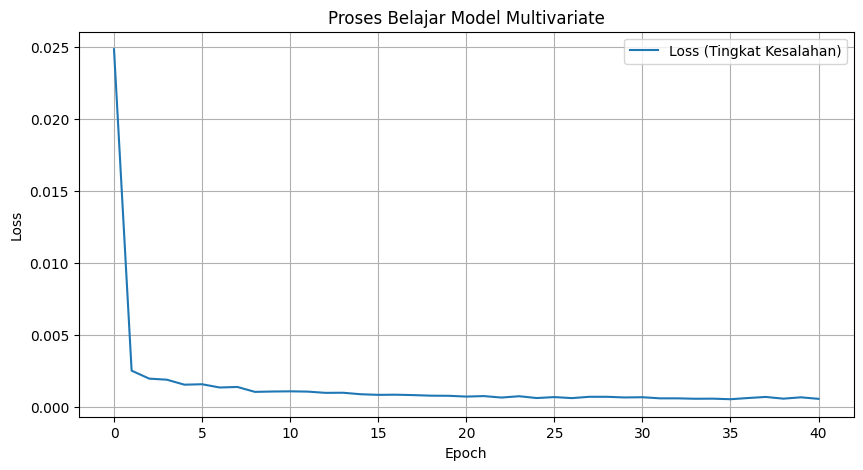

In [26]:
# Visualisasi
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Loss (Tingkat Kesalahan)')
plt.title('Proses Belajar Model Multivariate')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Uji Coba & Visualisasi

In [27]:
# Lakukan Prediksi

# AI menebak berdasarkan 4 fitur (X_test)
predictions = model.predict(X_test)

# Kembalikan ke Rupiah (Inverse Transform)
# PENTING: Kita pakai 'scaler_y' karena ini adalah data Harga (Target)
predicted_prices = scaler_y.inverse_transform(predictions)
real_prices = scaler_y.inverse_transform(y_test)

# Hitung Skor Error (RMSE)
rmse = math.sqrt(mean_squared_error(real_prices, predicted_prices))
print(f"Skor RMSE Model Multivariate: Rp {rmse:.2f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Skor RMSE Model Multivariate: Rp 128.56


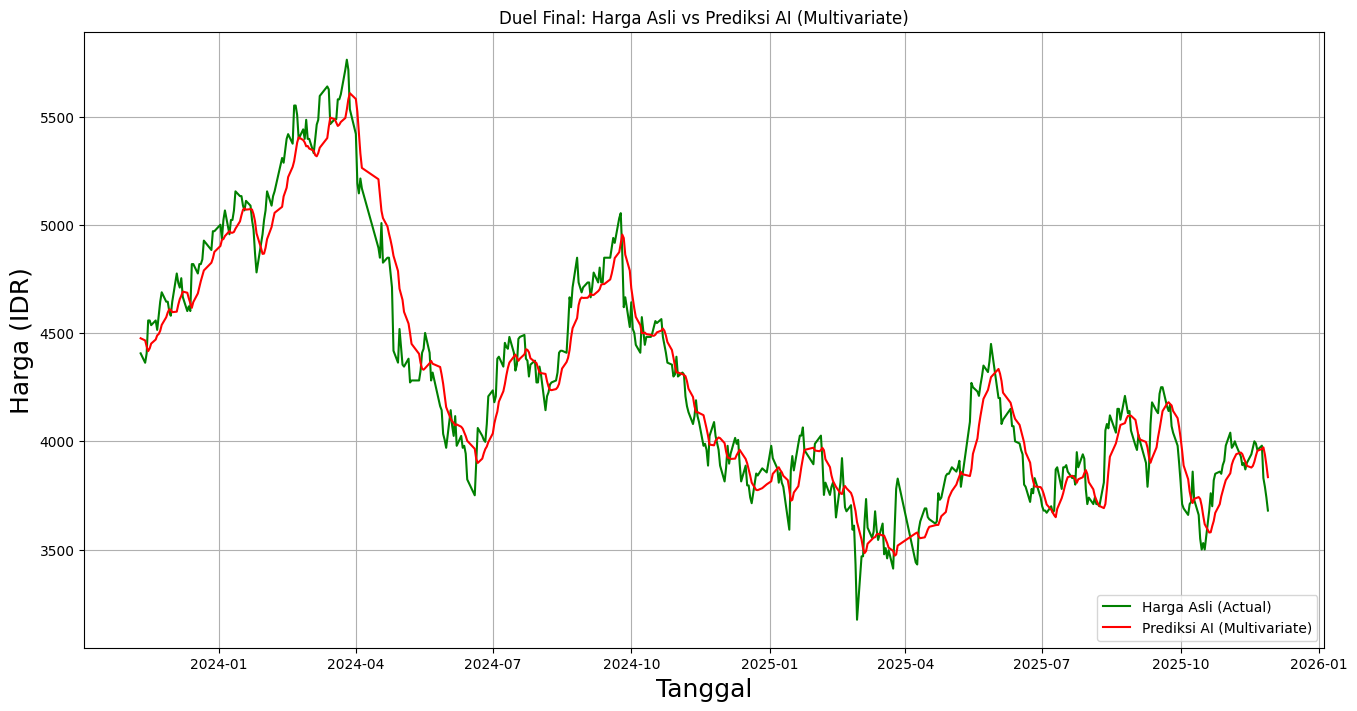

In [28]:
# Visualisasi Perbandingan

# Kita buat DataFrame sementara biar gampang di-plot dengan tanggal
train_len = len(df_multivariate) - len(y_test)
valid_data = df_multivariate[train_len:].copy()
valid_data['Predictions'] = predicted_prices

plt.figure(figsize=(16, 8))
plt.title('Duel Final: Harga Asli vs Prediksi AI (Multivariate)')
plt.xlabel('Tanggal', fontsize=18)
plt.ylabel('Harga (IDR)', fontsize=18)

# Gambar Harga Asli (Hijau)
plt.plot(valid_data['Close'], label='Harga Asli (Actual)', color='green')

# Gambar Prediksi AI (Merah)
plt.plot(valid_data['Predictions'], label='Prediksi AI (Multivariate)', color='red')

plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [29]:
# Cek 5 hari terakhir
print("5 Hari Terakhir (Asli vs Prediksi):")
print(valid_data[['Close', 'Predictions']].tail(10))

5 Hari Terakhir (Asli vs Prediksi):
Price        Close  Predictions
Ticker     BBRI.JK             
Date                           
2025-11-17  3940.0  3878.896484
2025-11-18  3970.0  3886.284668
2025-11-19  4000.0  3905.493896
2025-11-20  3990.0  3932.983398
2025-11-21  3960.0  3955.987061
2025-11-24  3980.0  3964.676758
2025-11-25  3830.0  3972.057617
2025-11-26  3790.0  3938.773193
2025-11-27  3740.0  3890.058105
2025-11-28  3680.0  3834.501465


In [30]:
# 1. Hitung Metrics
mae = mean_absolute_error(real_prices, predicted_prices)
rmse = np.sqrt(np.mean((real_prices - predicted_prices) ** 2))
mape = np.mean(np.abs((real_prices - predicted_prices) / real_prices)) * 100

# 2. Hitung Directional Accuracy (Akurasi Arah)
# Cek arah pergerakan (Hari ini - Kemarin)
real_direction = np.sign(np.diff(real_prices.flatten()))
pred_direction = np.sign(np.diff(predicted_prices.flatten()))
directional_acc = np.mean(real_direction == pred_direction) * 100

print(f"📊 LAPORAN EVALUASI MODEL FINAL")
print(f"==================================")
print(f"1. RMSE (Root Mean Squared Error) : Rp {rmse:.2f}")
print(f"   -> Rata-rata kesalahan dengan hukuman berat pada outlier.")
print(f"2. MAE (Mean Absolute Error)      : Rp {mae:.2f}")
print(f"   -> Rata-rata selisih harga secara umum.")
print(f"3. MAPE (Percentage Error)        : {mape:.2f}%")
print(f"   -> Tingkat kesalahan relatif dalam persen.")
print(f"4. Directional Accuracy           : {directional_acc:.2f}%")
print(f"   -> Seberapa sering AI benar menebak arah (Naik/Turun).")

📊 LAPORAN EVALUASI MODEL FINAL
1. RMSE (Root Mean Squared Error) : Rp 128.56
   -> Rata-rata kesalahan dengan hukuman berat pada outlier.
2. MAE (Mean Absolute Error)      : Rp 103.92
   -> Rata-rata selisih harga secara umum.
3. MAPE (Percentage Error)        : 2.45%
   -> Tingkat kesalahan relatif dalam persen.
4. Directional Accuracy           : 48.97%
   -> Seberapa sering AI benar menebak arah (Naik/Turun).


## Tes Terakhir: Ramalan Besok (Multivariate)

In [31]:
# Ambil 60 hari terakhir dari data 4 FITUR (bukan cuma harga)
last_60_days_multi = scaled_features[-60:]

# Bentuk ulang jadi 3 Dimensi (1 sampel, 60 hari, 4 fitur)
X_future_multi = []
X_future_multi.append(last_60_days_multi)
X_future_multi = np.array(X_future_multi)
X_future_multi = np.reshape(X_future_multi, (X_future_multi.shape[0], X_future_multi.shape[1], 4))

# Prediksi
pred_future_multi = model.predict(X_future_multi)

# Kembalikan ke Rupiah pakai scaler_y (khusus harga)
pred_future_price_multi = scaler_y.inverse_transform(pred_future_multi)

print(f"🔮 Prediksi Harga BBRI Besok (Multivariate): Rp {pred_future_price_multi[0][0]:,.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
🔮 Prediksi Harga BBRI Besok (Multivariate): Rp 3,775.68


## Simpan model

In [32]:
print("Sedang menyimpan aset berharga Anda... 📦")

# 1. Simpan Model LSTM (.keras)
model.save('model_bbri_multivariate.keras')

# 2. Simpan Scaler (.pkl)
# Ini untuk menerjemahkan Rupiah <-> Angka 0-1
joblib.dump(scaler_X, 'scaler_X.pkl')   # Scaler Fitur (Close, RSI, MACD)
joblib.dump(scaler_y, 'scaler_y.pkl')   # Scaler Target (Harga Rupiah)

print("Penyimpanan selesai di Cloud!")
print("Sekarang mengirim file ke komputer Anda...")

# Download ke Komputer
files.download('model_bbri_multivariate.keras')
files.download('scaler_X.pkl')
files.download('scaler_y.pkl')

Sedang menyimpan aset berharga Anda... 📦
Penyimpanan selesai di Cloud!
Sekarang mengirim file ke komputer Anda...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Modelling untuk 5 saham

In [33]:
# 1. KONFIGURASI PABRIK
daftar_saham = ['BBRI.JK', 'TLKM.JK', 'ASII.JK', 'ANTM.JK', 'ICBP.JK']
window_size = 60
epochs_max = 100  # Kita set tinggi, nanti EarlyStopping yang ngerem

# 2. FUNGSI BANTUAN
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).ewm(com=window-1, min_periods=window).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(com=window-1, min_periods=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def create_multivariate_dataset(X, y, time_step=60):
    data_X, data_Y = [], []
    for i in range(len(X) - time_step):
        data_X.append(X[i:(i + time_step)])
        data_Y.append(y[i + time_step])
    return np.array(data_X), np.array(data_Y)

# 3. MESIN LOOPING UTAMA
print(f"🏭 MEMULAI LOOPING (MULTIVARIATE + EARLY STOPPING)...\n")

for stock in daftar_saham:
    print(f"==================================================")
    print(f"🚀 Sedang Memproses: {stock}")

    # --- A. Data Ingestion ---
    # Ambil data sampai hari ini banget
    df = yf.download(stock, start='2015-01-01', end='2025-12-31', progress=False, auto_adjust=True)

    # Ratakan header jika perlu
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    if len(df) == 0:
        print(f"⚠️ Gagal download {stock}, skip...")
        continue

    # --- B. Feature Engineering ---
    df['RSI'] = calculate_rsi(df)
    k = df['Close'].ewm(span=12, adjust=False, min_periods=12).mean()
    d = df['Close'].ewm(span=26, adjust=False, min_periods=26).mean()
    df['MACD'] = k - d
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False, min_periods=9).mean()

    df_clean = df.dropna()

    # --- C. Scaling ---
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))

    feature_cols = ['Close', 'RSI', 'MACD', 'Signal']
    target_col = ['Close']

    scaled_features = scaler_X.fit_transform(df_clean[feature_cols])
    scaled_target = scaler_y.fit_transform(df_clean[target_col])

    # --- D. Windowing ---
    X, y = create_multivariate_dataset(scaled_features, scaled_target, window_size)

    # Train Test Split
    train_size = int(len(X) * 0.8)
    X_train, y_train = X[:train_size], y[:train_size]
    # Kita butuh validation data untuk Early Stopping
    X_test, y_test = X[train_size:], y[train_size:]

    # --- E. Modeling ---
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 4))) # 4 Fitur
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    # --- F. Training dengan Early Stopping ---
    callback_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    print(f"🏋️ Melatih model {stock}...")
    # Kita pasang validation_data dan callbacks
    history = model.fit(X_train, y_train,
                        batch_size=32,
                        epochs=epochs_max,
                        verbose=0,
                        validation_data=(X_test, y_test),
                        callbacks=[callback_stop])

    # Cek dia berhenti di epoch berapa
    epoch_akhir = len(history.history['loss'])
    print(f"✅ Selesai! Model berhenti optimal di Epoch {epoch_akhir}.")

    # --- G. Saving ---
    nama_bersih = stock.replace('.JK', '')
    model.save(f"model_{nama_bersih}.keras")
    joblib.dump(scaler_X, f"scaler_X_{nama_bersih}.pkl")
    joblib.dump(scaler_y, f"scaler_y_{nama_bersih}.pkl")
    print(f"💾 Aset tersimpan untuk {stock}.\n")

# 4. PACKAGING
print("📦 Memaketkan ke ZIP...")
zip_filename = "Model_Saham_Multivariate_Terbaik.zip"
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for stock in daftar_saham:
        nama_bersih = stock.replace('.JK', '')
        # Cek dulu filenya ada gak (jaga-jaga kalau ada saham yg gagal download)
        if os.path.exists(f"model_{nama_bersih}.keras"):
            zipf.write(f"model_{nama_bersih}.keras")
            zipf.write(f"scaler_X_{nama_bersih}.pkl")
            zipf.write(f"scaler_y_{nama_bersih}.pkl")

print(f"✅ SIAP! Mendownload {zip_filename}...")
files.download(zip_filename)

🏭 MEMULAI LOOPING (MULTIVARIATE + EARLY STOPPING)...

🚀 Sedang Memproses: BBRI.JK
🏋️ Melatih model BBRI.JK...
✅ Selesai! Model berhenti optimal di Epoch 29.
💾 Aset tersimpan untuk BBRI.JK.

🚀 Sedang Memproses: TLKM.JK
🏋️ Melatih model TLKM.JK...
✅ Selesai! Model berhenti optimal di Epoch 68.
💾 Aset tersimpan untuk TLKM.JK.

🚀 Sedang Memproses: ASII.JK
🏋️ Melatih model ASII.JK...
✅ Selesai! Model berhenti optimal di Epoch 14.
💾 Aset tersimpan untuk ASII.JK.

🚀 Sedang Memproses: ANTM.JK
🏋️ Melatih model ANTM.JK...
✅ Selesai! Model berhenti optimal di Epoch 7.
💾 Aset tersimpan untuk ANTM.JK.

🚀 Sedang Memproses: ICBP.JK
🏋️ Melatih model ICBP.JK...
✅ Selesai! Model berhenti optimal di Epoch 15.
💾 Aset tersimpan untuk ICBP.JK.

📦 Memaketkan ke ZIP...
✅ SIAP! Mendownload Model_Saham_Multivariate_Terbaik.zip...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Prediksi

In [34]:
def prediksi_saham_universal(kode_saham_input):
    # 1. Standarisasi Nama File
    ticker_clean = kode_saham_input.upper().replace('.JK', '')
    ticker_yf = f"{ticker_clean}.JK"

    print(f"\n🔍 Sedang mencari otak AI untuk {ticker_clean}...")

    # 2. Cek Apakah Model Tersedia?
    path_model = f"model_{ticker_clean}.keras"
    path_scaler_X = f"scaler_X_{ticker_clean}.pkl"
    path_scaler_y = f"scaler_y_{ticker_clean}.pkl"

    if not os.path.exists(path_model):
        print(f"❌ MAAF! Model untuk {ticker_clean} tidak ditemukan.")
        return

    # 3. Load Model & Scaler
    print("🧠 Memuat model dan kamus data...")
    try:
        model = load_model(path_model)
        scaler_X = joblib.load(path_scaler_X)
        scaler_y = joblib.load(path_scaler_y)
    except Exception as e:
        print(f"⚠️ File model rusak: {e}")
        return

    # 4. Ambil Data LIVE Terbaru
    print(f"📡 Mengambil data live {ticker_yf}...")
    # Kita ambil data cukup panjang untuk pastikan indikator terhitung benar
    df = yf.download(ticker_yf, period='6mo', progress=False, auto_adjust=True)

    # Ratakan header jika bertumpuk
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    if df.empty or len(df) < 60:
        print("⚠️ Data tidak ditemukan/kurang. Cek koneksi.")
        return

    # 5. Feature Engineering (Indikator)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).ewm(com=13, min_periods=14).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(com=13, min_periods=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    k = df['Close'].ewm(span=12, adjust=False, min_periods=12).mean()
    d = df['Close'].ewm(span=26, adjust=False, min_periods=26).mean()
    df['MACD'] = k - d
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False, min_periods=9).mean()

    df_clean = df.dropna()
    if len(df_clean) < 60:
        print("⚠️ Data bersih kurang.")
        return

    # 6. Siapkan Data Input
    # Ambil 60 hari terakhir dari data 4 FITUR (bukan cuma harga)
    input_features_df = df_clean[['Close', 'RSI', 'MACD', 'Signal']].tail(60)
    # Lakukan scaling, kirim DataFrame agar nama fitur tetap terjaga
    input_scaled = scaler_X.transform(input_features_df)
    input_tensor = tf.constant(input_scaled, dtype=tf.float32)
    input_tensor = tf.reshape(input_tensor, (1, 60, 4))

    # 7. Prediksi
    prediksi_scaled = model.predict(input_tensor, verbose=0)
    prediksi_rupiah = scaler_y.inverse_transform(prediksi_scaled)[0][0]
    harga_terakhir = df_clean['Close'].iloc[-1]

    # Perhitungan tanggal
    tgl_terakhir = df_clean.index[-1]
    str_tgl_terakhir = tgl_terakhir.strftime('%d %B %Y')

    # Tambah 1 hari dulu
    tgl_prediksi = tgl_terakhir + pd.Timedelta(days=1)

    # Cek Hari: 0=Senin, ..., 4=Jumat, 5=Sabtu, 6=Minggu
    # Jika harinya Sabtu (5) atau Minggu (6), geser terus sampai ketemu Senin
    while tgl_prediksi.dayofweek > 4:
        tgl_prediksi += pd.Timedelta(days=1)

    # Format nama hari biar jelas (Opsional, bahasa Inggris default)
    nama_hari = tgl_prediksi.strftime('%A') # Contoh: Monday
    str_tgl_prediksi = tgl_prediksi.strftime('%d %B %Y')

    # 8. Tampilkan Hasil
    selisih = prediksi_rupiah - harga_terakhir
    persentase = (selisih / harga_terakhir) * 100
    arah = "Nanjak 📈" if selisih > 0 else "Longsor 📉"

    print(f"\n========================================")
    print(f"🔮 HASIL PREDIKSI: {ticker_clean}")
    print(f"========================================")
    print(f"📅 Data Terakhir ({str_tgl_terakhir}) : Rp {harga_terakhir:,.2f}")
    print(f"🎯 Target ({nama_hari}, {str_tgl_prediksi}) : Rp {prediksi_rupiah:,.2f}")
    print(f"📊 Selisih                        : {selisih:+,.2f} ({persentase:+.2f}%)")
    print(f"🚦 Kesimpulan                     : {arah}")
    print(f"========================================")

    # 9. Visualisasi
    plt.figure(figsize=(10, 4))
    last_30 = df_clean['Close'].tail(30)
    plt.plot(last_30.index, last_30.values, label='Harga Asli', marker='o')
    plt.scatter(tgl_prediksi, prediksi_rupiah, color='red', s=100, label=f'Prediksi AI ({str_tgl_prediksi})', zorder=5)
    plt.title(f"Tren {ticker_clean} & Ramalan AI")
    plt.grid(True)
    plt.legend()
    plt.show()

Masukan kode saham untuk prediksi : bbri, tlkm, asii, antm, icbp

Masukkan Kode Saham: bbri

🔍 Sedang mencari otak AI untuk BBRI...
🧠 Memuat model dan kamus data...
📡 Mengambil data live BBRI.JK...

🔮 HASIL PREDIKSI: BBRI
📅 Data Terakhir (28 November 2025) : Rp 3,680.00
🎯 Target (Monday, 01 December 2025) : Rp 3,821.76
📊 Selisih                        : +141.76 (+3.85%)
🚦 Kesimpulan                     : Nanjak 📈


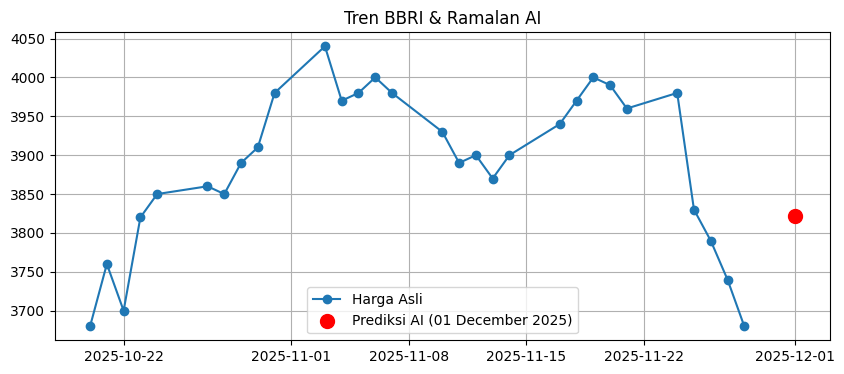


✅ Program selesai. Jalankan ulang sel ini jika ingin prediksi saham lain.


In [35]:
# Masukan input
kode = input("Masukkan Kode Saham: ")

# Cek apakah user mengetik sesuatu (tidak kosong)
if kode.strip():
    try:
        # Jalankan prediksi sekali saja
        prediksi_saham_universal(kode)
        print("\n✅ Program selesai. Jalankan ulang sel ini jika ingin prediksi saham lain.")
    except Exception as e:
        print(f"Terjadi kesalahan: {e}")
else:
    print("⚠️ Anda tidak memasukkan kode saham apa pun.")

Masukkan Kode Saham: tlkm

🔍 Sedang mencari otak AI untuk TLKM...
🧠 Memuat model dan kamus data...
📡 Mengambil data live TLKM.JK...

🔮 HASIL PREDIKSI: TLKM
📅 Data Terakhir (28 November 2025) : Rp 3,510.00
🎯 Target (Monday, 01 December 2025) : Rp 3,538.74
📊 Selisih                        : +28.74 (+0.82%)
🚦 Kesimpulan                     : Nanjak 📈


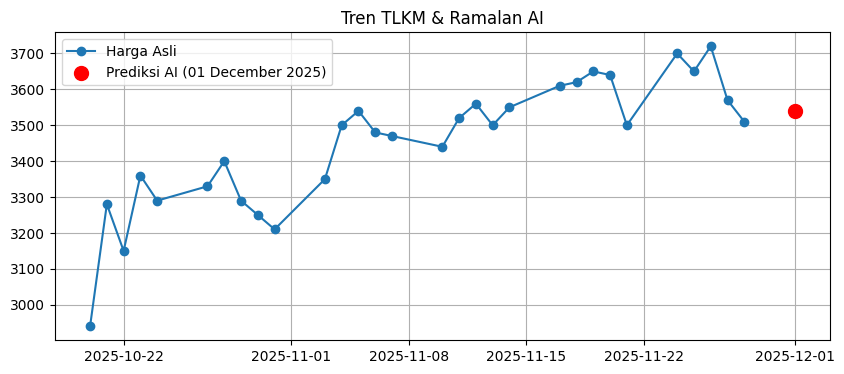


✅ Program selesai. Jalankan ulang sel ini jika ingin prediksi saham lain.


In [36]:
# Masukan input
kode = input("Masukkan Kode Saham: ")

# Cek apakah user mengetik sesuatu (tidak kosong)
if kode.strip():
    try:
        # Jalankan prediksi sekali saja
        prediksi_saham_universal(kode)
        print("\n✅ Program selesai. Jalankan ulang sel ini jika ingin prediksi saham lain.")
    except Exception as e:
        print(f"Terjadi kesalahan: {e}")
else:
    print("⚠️ Anda tidak memasukkan kode saham apa pun.")

Masukkan Kode Saham: asii

🔍 Sedang mencari otak AI untuk ASII...
🧠 Memuat model dan kamus data...
📡 Mengambil data live ASII.JK...



🔮 HASIL PREDIKSI: ASII
📅 Data Terakhir (28 November 2025) : Rp 6,550.00
🎯 Target (Monday, 01 December 2025) : Rp 6,466.39
📊 Selisih                        : -83.61 (-1.28%)
🚦 Kesimpulan                     : Longsor 📉


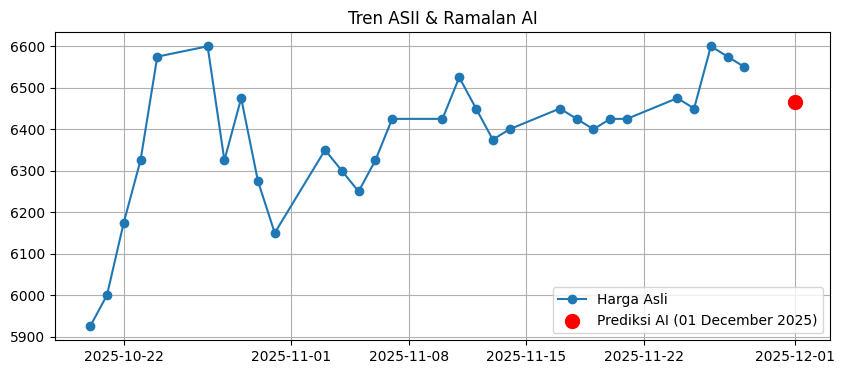


✅ Program selesai. Jalankan ulang sel ini jika ingin prediksi saham lain.


In [37]:
# Masukan input
kode = input("Masukkan Kode Saham: ")

# Cek apakah user mengetik sesuatu (tidak kosong)
if kode.strip():
    try:
        # Jalankan prediksi sekali saja
        prediksi_saham_universal(kode)
        print("\n✅ Program selesai. Jalankan ulang sel ini jika ingin prediksi saham lain.")
    except Exception as e:
        print(f"Terjadi kesalahan: {e}")
else:
    print("⚠️ Anda tidak memasukkan kode saham apa pun.")

Masukkan Kode Saham: antm

🔍 Sedang mencari otak AI untuk ANTM...
🧠 Memuat model dan kamus data...
📡 Mengambil data live ANTM.JK...



🔮 HASIL PREDIKSI: ANTM
📅 Data Terakhir (28 November 2025) : Rp 2,910.00
🎯 Target (Monday, 01 December 2025) : Rp 2,921.63
📊 Selisih                        : +11.63 (+0.40%)
🚦 Kesimpulan                     : Nanjak 📈


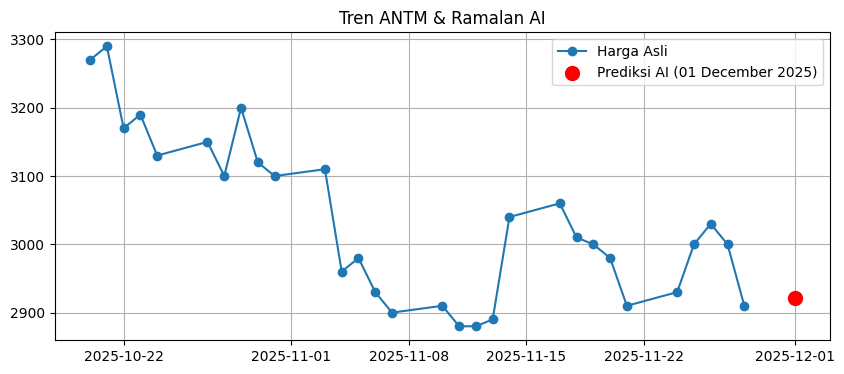


✅ Program selesai. Jalankan ulang sel ini jika ingin prediksi saham lain.


In [38]:
# Masukan input
kode = input("Masukkan Kode Saham: ")

# Cek apakah user mengetik sesuatu (tidak kosong)
if kode.strip():
    try:
        # Jalankan prediksi sekali saja
        prediksi_saham_universal(kode)
        print("\n✅ Program selesai. Jalankan ulang sel ini jika ingin prediksi saham lain.")
    except Exception as e:
        print(f"Terjadi kesalahan: {e}")
else:
    print("⚠️ Anda tidak memasukkan kode saham apa pun.")

Masukkan Kode Saham: icbp

🔍 Sedang mencari otak AI untuk ICBP...
🧠 Memuat model dan kamus data...
📡 Mengambil data live ICBP.JK...

🔮 HASIL PREDIKSI: ICBP
📅 Data Terakhir (28 November 2025) : Rp 8,450.00
🎯 Target (Monday, 01 December 2025) : Rp 8,552.49
📊 Selisih                        : +102.49 (+1.21%)
🚦 Kesimpulan                     : Nanjak 📈


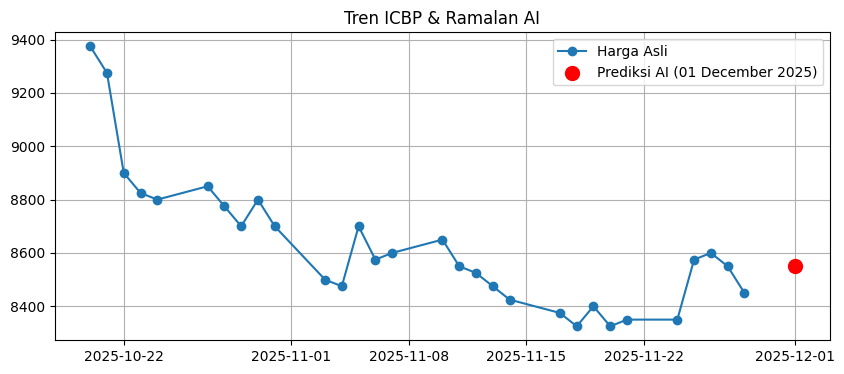


✅ Program selesai. Jalankan ulang sel ini jika ingin prediksi saham lain.


In [39]:
# Masukan input
kode = input("Masukkan Kode Saham: ")

# Cek apakah user mengetik sesuatu (tidak kosong)
if kode.strip():
    try:
        # Jalankan prediksi sekali saja
        prediksi_saham_universal(kode)
        print("\n✅ Program selesai. Jalankan ulang sel ini jika ingin prediksi saham lain.")
    except Exception as e:
        print(f"Terjadi kesalahan: {e}")
else:
    print("⚠️ Anda tidak memasukkan kode saham apa pun.")